In [1]:
# stock imports
import numpy as np
import pandas as pd
import json
import scipy
import random


##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

from scripts import prior_funcs, utils

# plt.style.use('dark_background')
plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

# tinygp
import tinygp

In [2]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = (
    ["radius", "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
    + ["nu_max"]
)

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,2.370506e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,1.156533e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.317504e+02,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,1.444480e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,2.352665e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,3.185873e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,5.856447e+03,7.993034e+03


## randomly sample a and b for each hare

In [245]:
a_vals = -5 # np.random.uniform(-10,2,len(df))
b_vals = 5 # np.random.uniform(4.4,5.25,len(df))

gp_df = df[[f"nu_0_{i}" for i in range(6, 41)] + ["nu_max"]]

gp_df.insert(len(gp_df.columns), 'a',a_vals)
gp_df.insert(len(gp_df.columns), 'b',b_vals)

In [246]:
def surf_corr(freqs, nu_max, a, b):
    return a * ((freqs / nu_max) ** b)

freq_cols = [f"nu_0_{i}" for i in range(6, 41)]


corr_array = surf_corr(gp_df[freq_cols].values, gp_df['nu_max'].values[:, np.newaxis] , gp_df['a'].values[:, np.newaxis] , gp_df['b'].values[:, np.newaxis])
corr_df = pd.DataFrame(corr_array, columns=[f"nu_0_{i}_corr" for i in range(6, 41)])

In [250]:
gp_df

,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,nu_0_13,nu_0_14,nu_0_15,...,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,a,b
25,1425.025739,1640.788534,1856.670741,2068.576748,2278.205135,2483.758257,2685.680992,2886.399995,3086.007206,3285.791165,...,7080.125114,7281.410804,7482.218858,7682.112868,7878.505679,8069.321307,8262.381500,5036.887428,-5,5
26,1422.626112,1638.011410,1853.510087,2065.048531,2274.286404,2479.468010,2681.021352,2881.386625,3080.654100,3280.085129,...,7067.976700,7268.908386,7469.361337,7668.869983,7864.708271,8055.309602,8247.951540,5025.229740,-5,5
27,1420.087794,1635.074382,1850.167473,2061.317309,2270.143065,2474.930634,2676.094050,2876.084516,3074.992278,3274.050251,...,7055.131017,7255.687277,7455.763406,7654.861279,7850.074450,8040.485289,8232.681026,5012.780107,-5,5
28,1417.366998,1631.927011,1846.585530,2057.319088,2265.704013,2470.068160,2670.814353,2870.402603,3068.924315,3267.582685,...,7041.369424,7241.522616,7441.193530,7639.848000,7834.337311,8024.595862,8216.309583,4999.337256,-5,5
29,1415.227972,1629.452939,1843.769979,2054.176210,2262.215113,2466.245630,2666.664081,2865.936001,3064.153673,3262.498258,...,7030.552201,7230.388078,7429.738758,7628.042425,7821.912829,8012.099692,8203.432041,4988.713305,-5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8141480,235.792046,268.260392,299.667242,331.427293,362.981918,393.941684,425.196015,456.933750,488.741217,520.649761,...,1119.926951,1152.804058,1185.651780,1218.434938,1251.093358,1283.611516,1315.958063,504.521189,-5,5
8141482,232.976816,265.004694,296.017457,327.398117,358.550172,389.135126,420.041791,451.403010,482.815394,514.340764,...,1106.427944,1138.914775,1171.361599,1203.747128,1235.986184,1268.086219,1300.018592,497.064167,-5,5
8141484,230.329849,261.946850,292.591572,323.613765,354.384591,384.616831,415.197027,446.206045,477.250282,508.416717,...,1093.752677,1125.870126,1157.939044,1189.949939,1221.798348,1253.506063,1285.045263,490.052502,-5,5
8141486,227.814313,259.042756,289.339400,320.019769,350.427058,380.324648,410.594737,441.269606,471.965757,502.792349,...,1081.721485,1113.484419,1145.193421,1176.847548,1208.329347,1239.665948,1270.827431,483.388530,-5,5


In [251]:
corr_df

,nu_0_6_corr,nu_0_7_corr,nu_0_8_corr,nu_0_9_corr,nu_0_10_corr,nu_0_11_corr,nu_0_12_corr,nu_0_13_corr,nu_0_14_corr,nu_0_15_corr,...,nu_0_31_corr,nu_0_32_corr,nu_0_33_corr,nu_0_34_corr,nu_0_35_corr,nu_0_36_corr,nu_0_37_corr,nu_0_38_corr,nu_0_39_corr,nu_0_40_corr
0,-0.009063,-0.018341,-0.034028,-0.058414,-0.094651,-0.145783,-0.215492,-0.308988,-0.431662,-0.590689,...,-17.560275,-20.469499,-23.750507,-27.438694,-31.567228,-36.166861,-41.263133,-46.814247,-52.764743,-59.386127
1,-0.009092,-0.018398,-0.034132,-0.058592,-0.094933,-0.146212,-0.216118,-0.309883,-0.432917,-0.592401,...,-17.612907,-20.530896,-23.821847,-27.521110,-31.661856,-36.275027,-41.385411,-46.946529,-52.917776,-59.555366
2,-0.009123,-0.018461,-0.034248,-0.058790,-0.095245,-0.146687,-0.216812,-0.310874,-0.434307,-0.594297,...,-17.671123,-20.598809,-23.900751,-27.612272,-31.766511,-36.394631,-41.520575,-47.091835,-53.086983,-59.742471
3,-0.009158,-0.018532,-0.034376,-0.059009,-0.095592,-0.147215,-0.217584,-0.311977,-0.435852,-0.596404,...,-17.735845,-20.674314,-23.988470,-27.713634,-31.882861,-36.527574,-41.670760,-47.251887,-53.275027,-59.950361
4,-0.009187,-0.018588,-0.034480,-0.059186,-0.095873,-0.147642,-0.218207,-0.312867,-0.437099,-0.598107,...,-17.788118,-20.735300,-24.059314,-27.795498,-31.976823,-36.634898,-41.791963,-47.379681,-53.426779,-60.118093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2448676,-0.111486,-0.212498,-0.369632,-0.611666,-0.963824,-1.451218,-2.125783,-3.046766,-4.265479,-5.851960,...,-170.469459,-199.346896,-232.230125,-269.476830,-311.422820,-358.392357,-410.756713,-468.836638,-533.016894,-603.647209
2448677,-0.113102,-0.215365,-0.374537,-0.619853,-0.976467,-1.470313,-2.154618,-3.088375,-4.323279,-5.931471,...,-172.813880,-202.109562,-235.461838,-273.226866,-315.764902,-363.381350,-416.470305,-475.308742,-540.320736,-611.864897
2448678,-0.114685,-0.218184,-0.379373,-0.627902,-0.988852,-1.489013,-2.182871,-3.129206,-4.380139,-6.009745,...,-175.122029,-204.828799,-238.644712,-276.918898,-320.035702,-368.286196,-422.085473,-481.675568,-547.506330,-619.939166
2448679,-0.116250,-0.220976,-0.384172,-0.635876,-1.001098,-1.507512,-2.210829,-3.169629,-4.436503,-6.087397,...,-177.414148,-207.529614,-241.807094,-280.585727,-324.271678,-373.149204,-427.650842,-487.994485,-554.640598,-627.944413


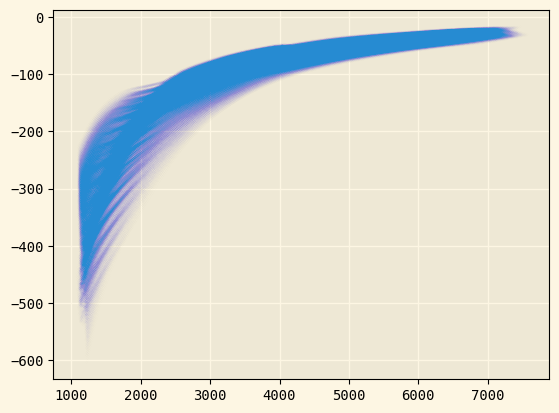

In [247]:
i = 35
plt.scatter(gp_df[f'nu_0_{i}'], corr_df[f'nu_0_{i}_corr'], s=0.05, alpha=0.006)

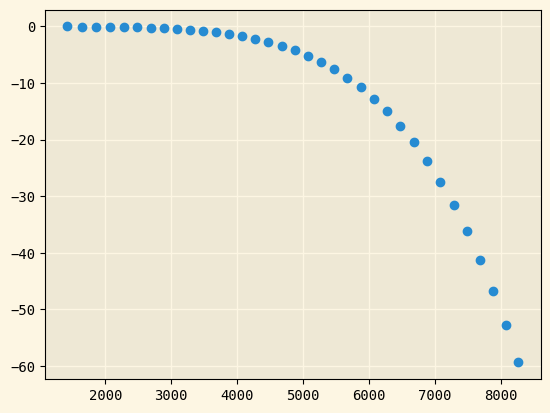

In [255]:
row=0#
plt.scatter(gp_df[[f'nu_0_{i}' for i in range(6, 41)]].iloc[row], corr_df[[f"nu_0_{i}_corr" for i in range(6, 41)]].iloc[row])

In [9]:
row_array = np.tile([i for i in range(6, 41)], (len(df),1))
row_array.shape

(2448681, 35)

In [10]:
corr_df[[f"nu_0_{i}_corr" for i in range(6, 41)]].shape

(2448681, 35)

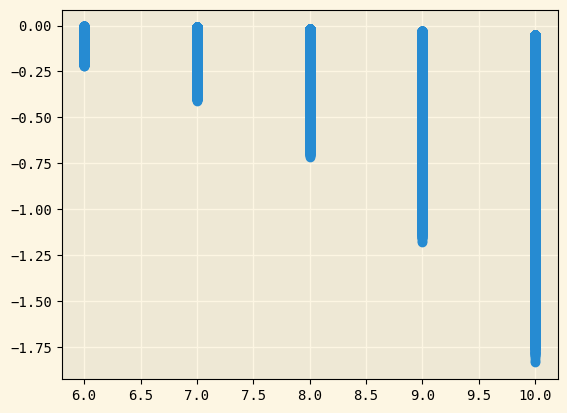

In [15]:
plt.scatter(row_array[:,:5], corr_df[[f"nu_0_{i}_corr" for i in range(6, 41)]].values[:,:5])

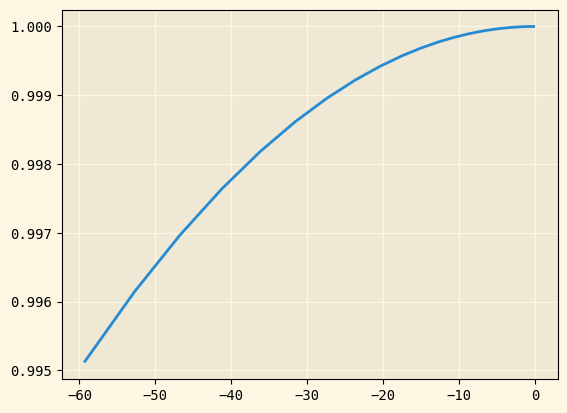

In [35]:
def surf_corr(freqs, nu_max, a, b):
    return a * ((freqs / nu_max) ** b)

def squared_exp_kernel(dx,s,l):
    return (s**2) * np.exp(-((-dx)**2)/(2*(l**2)))

dx = surf_corr(df[[f"nu_0_{i}" for i in range(6, 41)]].iloc[0].values,df['nu_max'].iloc[0], -5,5)

plt.plot(dx, squared_exp_kernel(dx, 1, 600))

In [165]:
import jax

jax.config.update("jax_enable_x64", True)


In [6]:
from tinygp import GaussianProcess
from tinygp import kernels


kernel = kernels.ExpSquared(scale=600)
X = np.linspace(1500,4000, 100)
gp = GaussianProcess(kernel, X)

Gaussian

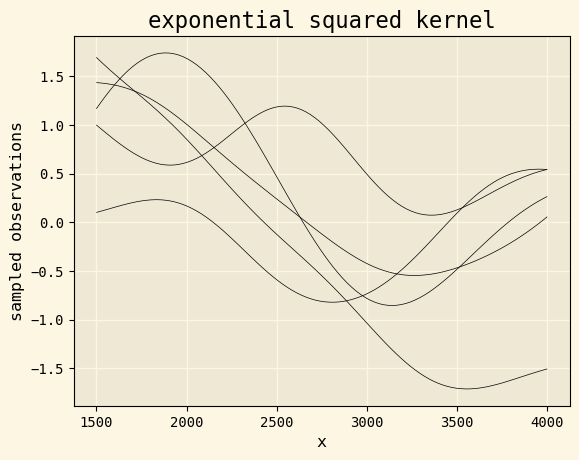

In [9]:
y = gp.sample(jax.random.PRNGKey(5), shape=(5,))
plt.plot(X, y.T, color="k", lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

In [14]:
kernel = kernels.ExpSquared(scale=600)

x = df[[f"nu_0_{i}" for i in range(6, 41)]].iloc[0].values
y = corr_df[[f"nu_0_{i}_corr" for i in range(6, 41)]].iloc[0].values

gp = GaussianProcess(kernel, x)

print(gp.log_probability(y))

-3437.8854442199827


In [15]:
y

array([-9.06300718e-03, -1.83409507e-02, -3.40277512e-02, -5.84140037e-02,
       -9.46505001e-02, -1.45782502e-01, -2.15491879e-01, -3.08987817e-01,
       -4.31661644e-01, -5.90688572e-01, -7.92177019e-01, -1.04377641e+00,
       -1.35531887e+00, -1.73690657e+00, -2.20223633e+00, -2.76319140e+00,
       -3.43372295e+00, -4.23030142e+00, -5.16887587e+00, -6.27060090e+00,
       -7.55489753e+00, -9.04495347e+00, -1.07648510e+01, -1.27376075e+01,
       -1.49947212e+01, -1.75602747e+01, -2.04694991e+01, -2.37505074e+01,
       -2.74386944e+01, -3.15672282e+01, -3.61668610e+01, -4.12631330e+01,
       -4.68142471e+01, -5.27647427e+01, -5.93861266e+01])

0.16462032491346346


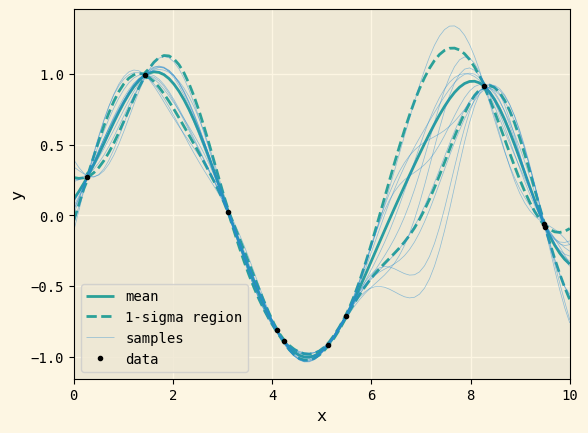

In [17]:
# Simulate a made up dataset, as an example
random = np.random.default_rng(1)
X = np.sort(random.uniform(0, 10, 10))
y = np.sin(X) + 1e-4 * random.normal(size=X.shape)

# Compute the log probability
kernel = 0.5 * kernels.ExpSquared(scale=1.0)
gp = GaussianProcess(kernel, X, diag=1e-4)
print(gp.log_probability(y))


X_test = np.linspace(0, 10, 100)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.plot(X, y, ".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
_ = plt.ylabel("y")

-75.88319116541417


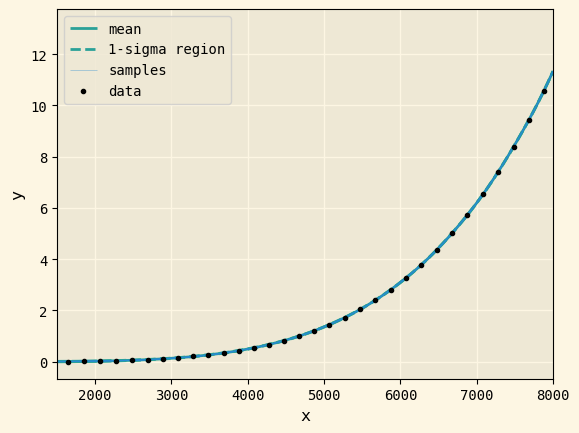

In [88]:
# Simulate a made up dataset, as an example
random = np.random.default_rng(1)
X = df[[f"nu_0_{i}" for i in range(6, 41)]].iloc[0].values
y = corr_df[[f"nu_0_{i}_corr" for i in range(6, 41)]].iloc[0].values

# Compute the log probability
kernel = kernels.ExpSquared(scale=600)
gp = GaussianProcess(kernel, X, diag=1e-4)
print(gp.log_probability(y))


X_test = np.linspace(1500, 8000, 100)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.plot(X, y, ".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
_ = plt.ylabel("y")

-55.34994140300006
-55.34994140300006


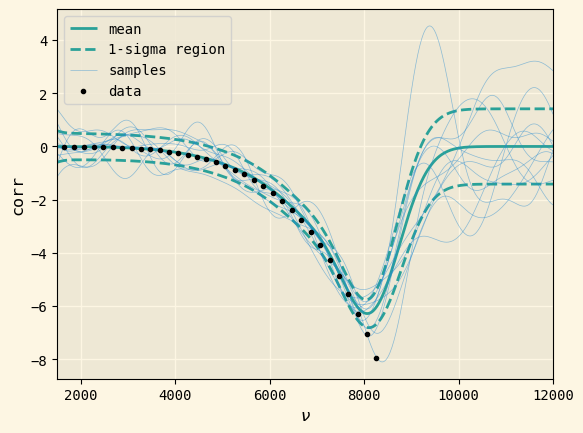

In [205]:
# Simulate a made up dataset, as an example
X = df[[f"nu_0_{i}" for i in range(6, 41)]].iloc[1].values.flatten()
y = corr_df[[f"nu_0_{i}_corr" for i in range(6, 41)]].iloc[1].values.flatten()

# Compute the log probability
kernel = 2*kernels.ExpSquared(scale=600)
gp = GaussianProcess(kernel, X, diag=1)
print(gp.log_probability(y))

cond = gp.condition(y)
print(cond.log_probability)

X_test = np.linspace(1500, 12000, 500)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.plot(X, y, ".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel(r"$\nu$")
_ = plt.ylabel(r"corr")

-8.683718630394033
-8.683718630394033


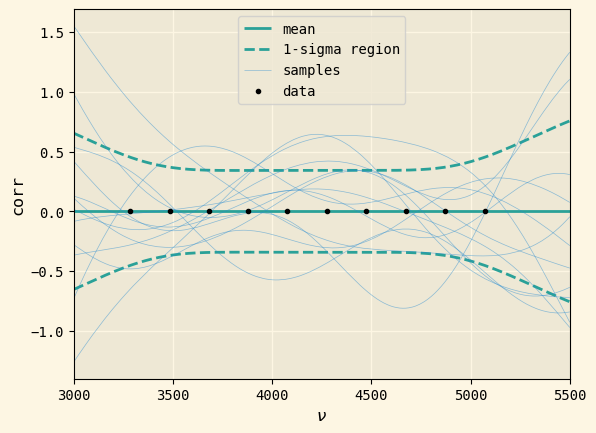

In [241]:
def surf_corr(freqs, nu_max, a, b):
    return a * ((freqs / nu_max) ** b)

def mean_function(params, X):
    return params['a'] * ((X / params['nu_max']) ** params['b'])

mean_params = {
    "a": 0,
    "b": 0,
    "nu_max": 2371,
}

# Simulate a made up dataset, as an example
X = df[[f"nu_0_{i}" for i in range(15, 25)]].iloc[0].values.flatten()

y = corr_df[[f"nu_0_{i}_corr" for i in range(15, 25)]].iloc[0].values.flatten()

# Compute the log probability
kernel = 1*kernels.ExpSquared(scale=600)
gp = GaussianProcess(kernel, X, diag=0.5, mean=partial(mean_function, mean_params))
print(gp.log_probability(y))

cond = gp.condition(y)
print(cond.log_probability)

X_test = np.linspace(3000, 5500, 500)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.plot(X, y, ".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel(r"$\nu$")
_ = plt.ylabel(r"corr")

-226336.62127953905
-226336.62127953905


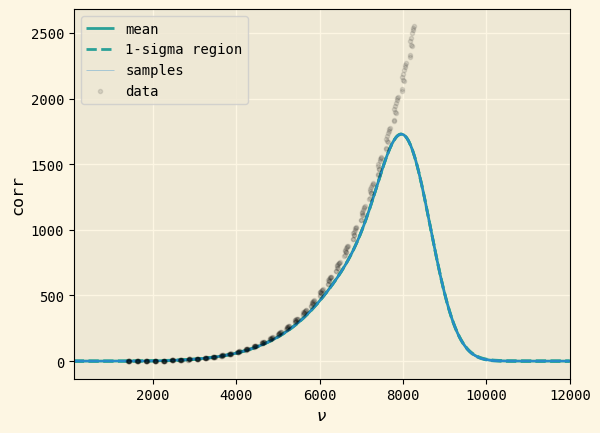

In [228]:
def surf_corr(freqs, nu_max, a, b):
    return a * ((freqs / nu_max) ** b)

def mean_function(params, X):
    return params['a'] * ((X / params['nu_max']) ** params['b'])

mean_params = {
    "a": -4,
    "b": 4,
    "nu_max": 2371,
}

# Simulate a made up dataset, as an example
X = df[[f"nu_0_{i}" for i in range(6, 41)]].iloc[:10].values.flatten()

y = corr_df[[f"nu_0_{i}_corr" for i in range(6, 41)]].iloc[:10].values.flatten() - surf_corr(X, 2371, -5,5)

# Compute the log probability
kernel = 10*kernels.ExpSquared(scale=600)
gp = GaussianProcess(kernel, X, diag=100)
print(gp.log_probability(y))

cond = gp.condition(y)
print(cond.log_probability)

X_test = np.linspace(100, 12000, 500)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.plot(X, y, ".k", label="data", alpha=0.1)
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel(r"$\nu$")
_ = plt.ylabel(r"corr")